In [1]:
## first block of code is just importing the requirements of the project

import sys 
import os
import h5py
import pickle
from matplotlib import pyplot as plt

from scipy import ndimage as ndi
from scipy import stats as sstats

import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from random import shuffle
from tqdm import tqdm, tnrange, tqdm_notebook
import collections
import random
import mahotas 
from sklearn.preprocessing import normalize
from PIL import Image
import imutils
import logging

from glob import glob

# this block of code is importing all the various parts of the project from their respective modules
from icon_util import *
from methods import *
from aberrations import *
from hyperion import hyperion

In [10]:
image_set_name = "icon1k"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])

# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i) if i.shape[0] == 3 else i for i in images[:100]]
print(len(images))
print("Loading Completed")

100
Loading Completed


In [11]:
# get image vectors using the neural method
nm = neural_method()
vecs=[]
c = 0
for i in images:
    c += 1
    print(c)
    vecs.append([nm.create_query(ab(i)) for ab in aberrations])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [13]:
# get precision and recall for various numbers of hyperplanes
def prec_recall(vecs, num_planes):
    #create a hyperplane dictionary
    hyp = hyperion(num_hyperpros=1, num_planes=num_planes)
    #learn the input set, that is the unmodified image vectors
    for idx, vs in enumerate(vecs):
        hyp.learn(idx, vs[0])
    # average number of results is the precision
    # number of queries that contain the input / total queries is the recall
    precision = 0
    hits = 0
    total = 0
    for idx, vs in enumerate(vecs):
        for v in vs:
            total += 1
            res = hyp(v)
            precision += len(res)
            if idx in res:
                hits += 1
    precision /= total
    recall = hits/total
    return precision, recall
print(prec_recall(vecs, 10))

(5.273125, 0.280625)


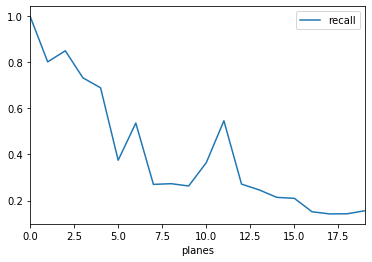

In [28]:
data = {}
for i in range(20):
    data.setdefault("planes",[]).append(i)
    p,r = prec_recall(vecs, i)
    data.setdefault("precision",[]).append(p)
    data.setdefault("recall",[]).append(r)
prdata = pd.DataFrame(data = data)
prdata.plot(x="planes", y="recall")